In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras.backend as K
from keras.layers import Layer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import RandomUniform, Initializer, Constant
import pandas as pd
import numpy as np
import math

## Preambulo: construyendo un RBF NN en Tensorflow

Extraído de: https://github.com/PetraVidnerova/rbf_for_tf2

In [2]:
class InitFromFile(Initializer):
    """ Initialize the weights by loading from file.
    # Arguments
        filename: name of file, should by .npy file
    """
    def __init__(self, filename):
        self.filename = filename
        super().__init__()

    def __call__(self, shape, dtype=None):
        with open(self.filename, "rb") as f:
            X = np.load(f, allow_pickle=True) # fails without allow_pickle
        assert tuple(shape) == tuple(X.shape)
        return X

    def get_config(self):
        return {
            'filename': self.filename
        }

In [3]:
class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter
        super().__init__()

    def __call__(self, shape, dtype=None):
        assert shape[1:] == self.X.shape[1:]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_

In [4]:
class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X
        super().__init__()

    def __call__(self, shape, dtype=None):
        assert shape[1:] == self.X.shape[1:]  # check dimension

        # np.random.randint returns ints from [low, high) !
        idx = np.random.randint(self.X.shape[0], size=shape[0])

        return self.X[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):

        self.output_dim = output_dim

        # betas is either initializer object or float
        if isinstance(betas, Initializer):
            self.betas_initializer = betas
        else:
            self.betas_initializer = Constant(value=betas)

        self.initializer = initializer if initializer else RandomUniform(
            0.0, 1.0)

        super().__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=self.betas_initializer,
                                     # initializer='ones',
                                     trainable=True)

        super().build(input_shape)

    def call(self, x):

        C = tf.expand_dims(self.centers, -1)  # inserts a dimension of 1
        H = tf.transpose(C-tf.transpose(x))  # matrix of differences
        return tf.exp(-self.betas * tf.math.reduce_sum(H**2, axis=1))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [5]:
### R squared

def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Cargando Data

In [6]:
## https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction#

data = pd.read_csv('energydata_complete.csv')
data

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,...,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,...,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,...,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,...,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784


## Análisis Exploratorio

- date time year-month-day hour:minute:second
- Appliances, energy use in Wh
- lights, energy use of light fixtures in the house in Wh
- T1, Temperature in kitchen area, in Celsius
- RH_1, Humidity in kitchen area, in %
- T2, Temperature in living room area, in Celsius
- RH_2, Humidity in living room area, in %
- T3, Temperature in laundry room area
- RH_3, Humidity in laundry room area, in %
- T4, Temperature in office room, in Celsius
- RH_4, Humidity in office room, in %
- T5, Temperature in bathroom, in Celsius
- RH_5, Humidity in bathroom, in %
- T6, Temperature outside the building (north side), in Celsius
- RH_6, Humidity outside the building (north side), in %
- T7, Temperature in ironing room , in Celsius
- RH_7, Humidity in ironing room, in %
- T8, Temperature in teenager room 2, in Celsius
- RH_8, Humidity in teenager room 2, in %
- T9, Temperature in parents room, in Celsius
- RH_9, Humidity in parents room, in %
- To, Temperature outside (from Chievres weather station), in Celsius
- Pressure (from Chievres weather station), in mm Hg
- RH_out, Humidity outside (from Chievres weather station), in %
- Wind speed (from Chievres weather station), in m/s
- Visibility (from Chievres weather station), in km
- Tdewpoint (from Chievres weather station), Â°C
- rv1, Random variable 1, nondimensional
- rv2, Random variable 2, nondimensional

In [7]:
data.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


In [8]:
data.isna().sum().sum()

0

In [9]:
data.corr()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
Appliances,1.000000,0.197278,0.055447,0.086031,0.120073,-0.060465,0.085060,0.036292,0.040281,0.016965,...,0.010010,-0.051462,0.099155,-0.034885,-0.152282,0.087122,0.000230,0.015353,-0.011145,-0.011145
lights,0.197278,1.000000,-0.023528,0.106968,-0.005622,0.050985,-0.097393,0.131161,-0.008859,0.114936,...,-0.157592,-0.008766,-0.074424,-0.010576,0.068543,0.060281,0.020038,-0.036322,0.000521,0.000521
T1,0.055447,-0.023528,1.000000,0.164006,0.836834,-0.002509,0.892402,-0.028550,0.877001,0.097861,...,0.844777,0.071756,0.682846,-0.150574,-0.345481,-0.087654,-0.076210,0.571309,-0.006203,-0.006203
RH_1,0.086031,0.106968,0.164006,1.000000,0.269839,0.797535,0.253230,0.844677,0.106180,0.880359,...,0.115263,0.764001,0.340767,-0.293957,0.274126,0.204932,-0.021057,0.639106,-0.000699,-0.000699
T2,0.120073,-0.005622,0.836834,0.269839,1.000000,-0.165610,0.735245,0.121497,0.762066,0.231563,...,0.675535,0.157346,0.792255,-0.133028,-0.505291,0.052495,-0.069721,0.582602,-0.011087,-0.011087
RH_2,-0.060465,0.050985,-0.002509,0.797535,-0.165610,1.000000,0.137319,0.678326,-0.047304,0.721435,...,0.054544,0.676467,0.033674,-0.255646,0.584911,0.069190,-0.005368,0.499152,0.006275,0.006275
T3,0.085060,-0.097393,0.892402,0.253230,0.735245,0.137319,1.000000,-0.011234,0.852778,0.122737,...,0.901324,0.134602,0.699417,-0.189974,-0.281718,-0.100776,-0.102310,0.645886,-0.005194,-0.005194
RH_3,0.036292,0.131161,-0.028550,0.844677,0.121497,0.678326,-0.011234,1.000000,-0.140457,0.898978,...,-0.195270,0.833538,0.118207,-0.233274,0.356192,0.263188,0.017041,0.414387,-0.000477,-0.000477
T4,0.040281,-0.008859,0.877001,0.106180,0.762066,-0.047304,0.852778,-0.140457,1.000000,-0.048650,...,0.889439,-0.025549,0.663478,-0.075292,-0.388602,-0.185747,-0.104768,0.519471,-0.001815,-0.001815
RH_4,0.016965,0.114936,0.097861,0.880359,0.231563,0.721435,0.122737,0.898978,-0.048650,1.000000,...,-0.044518,0.856591,0.293289,-0.250748,0.336813,0.300192,0.002636,0.616509,-0.001787,-0.001787


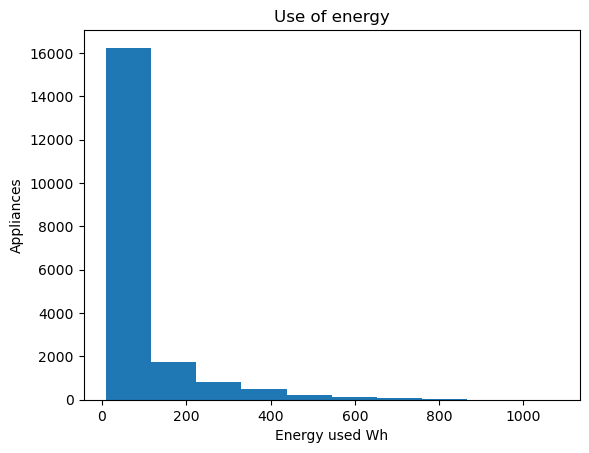

In [10]:
plt.hist(data['Appliances'])
plt.title('Use of energy')
plt.ylabel('Appliances')
plt.xlabel('Energy used Wh')
plt.show()

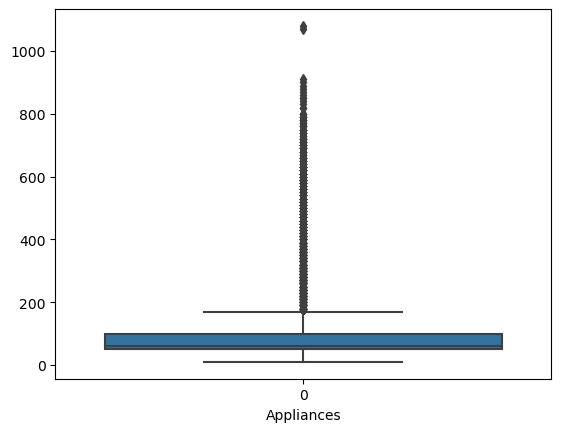

In [11]:
sns.boxplot(data['Appliances'])
plt.xlabel('Appliances')
plt.show()

In [12]:
p25 = data['Appliances'].quantile(0.25)
p75 = data['Appliances'].quantile(0.75)

iqr = p75 - p25

upper_limit = p75 + 1.5 * iqr
lower_limit = p25 - 1.5 * iqr

In [13]:
## Buscando outliers

print(data[data['Appliances'] > upper_limit])
print(data[data['Appliances'] < lower_limit])

                      date  Appliances  lights         T1       RH_1  \
10     2016-01-11 18:40:00         230      70  19.926667  45.863333   
11     2016-01-11 18:50:00         580      60  20.066667  46.396667   
12     2016-01-11 19:00:00         430      50  20.133333  48.000000   
13     2016-01-11 19:10:00         250      40  20.260000  52.726667   
21     2016-01-11 20:30:00         190      40  20.963333  47.633333   
...                    ...         ...     ...        ...        ...   
19725  2016-05-27 16:30:00         220       0  25.426667  46.060000   
19726  2016-05-27 16:40:00         180       0  25.500000  46.530000   
19732  2016-05-27 17:40:00         270      10  25.500000  46.596667   
19733  2016-05-27 17:50:00         420      10  25.500000  46.990000   
19734  2016-05-27 18:00:00         430      10  25.500000  46.600000   

              T2       RH_2         T3       RH_3     T4  ...         T9  \
10     19.356667  44.400000  19.790000  44.900000  18.89  .

In [14]:
## Sacando outliers

data1 = data[data['Appliances'] < upper_limit]
data1

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,17.033333,45.530000,6.600000,733.50,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,17.066667,45.560000,6.483333,733.60,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,17.000000,45.500000,6.366667,733.70,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,17.000000,45.400000,6.250000,733.80,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,17.000000,45.400000,6.133333,733.90,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19727,2016-05-27 16:50:00,120,0,25.500000,47.456667,26.000000,42.320000,27.663333,40.693333,24.700000,...,23.200000,46.718000,22.966667,755.25,55.000000,2.833333,22.166667,13.366667,1.796395,1.796395
19728,2016-05-27 17:00:00,110,0,25.600000,47.193333,25.968571,42.528571,27.390000,41.030000,24.700000,...,23.200000,46.751429,23.000000,755.20,55.000000,3.000000,22.000000,13.400000,18.248201,18.248201
19729,2016-05-27 17:10:00,90,0,25.533333,46.860000,25.978000,42.534000,27.323333,41.090000,24.700000,...,23.200000,46.745000,22.866667,755.20,55.333333,3.166667,22.833333,13.366667,16.966162,16.966162
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,...,23.200000,46.790000,22.733333,755.20,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812


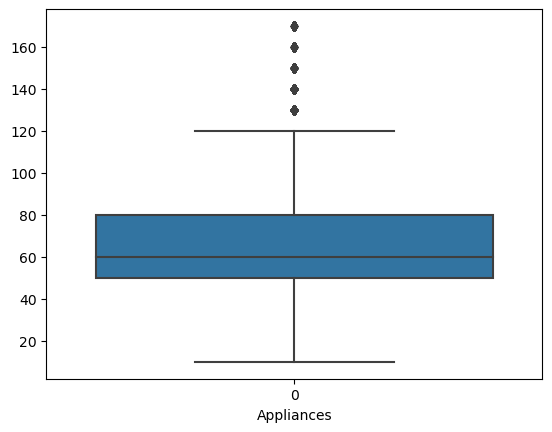

In [15]:
sns.boxplot(data1['Appliances'])
plt.xlabel('Appliances')
plt.show()

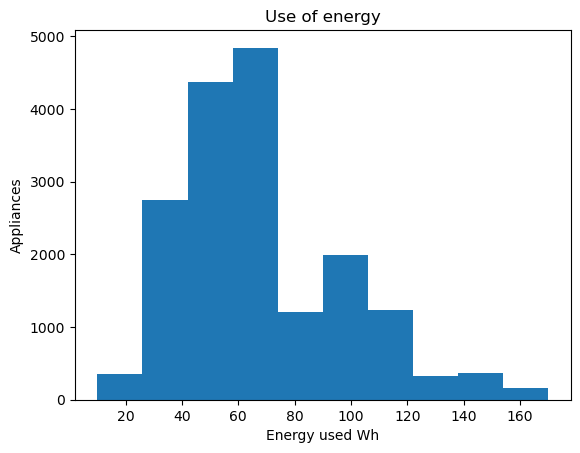

In [16]:
plt.hist(data1['Appliances'])
plt.title('Use of energy')
plt.ylabel('Appliances')
plt.xlabel('Energy used Wh')
plt.show()

## Feature selection y datasets de entrenamiento/prueba

In [17]:
## Preprocesado inicial de features

y = data1['Appliances']

x = data1.drop(columns = ['date','Appliances', 'rv1', 'rv2'])
x

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,17.166667,...,18.200000,48.900000,17.033333,45.530000,6.600000,733.50,92.000000,7.000000,63.000000,5.300000
1,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,17.166667,...,18.200000,48.863333,17.066667,45.560000,6.483333,733.60,92.000000,6.666667,59.166667,5.200000
2,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,17.166667,...,18.200000,48.730000,17.000000,45.500000,6.366667,733.70,92.000000,6.333333,55.333333,5.100000
3,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,17.166667,...,18.100000,48.590000,17.000000,45.400000,6.250000,733.80,92.000000,6.000000,51.500000,5.000000
4,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,17.200000,...,18.100000,48.590000,17.000000,45.400000,6.133333,733.90,92.000000,5.666667,47.666667,4.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19727,0,25.500000,47.456667,26.000000,42.320000,27.663333,40.693333,24.700000,45.560000,23.200000,...,24.540000,51.500000,23.200000,46.718000,22.966667,755.25,55.000000,2.833333,22.166667,13.366667
19728,0,25.600000,47.193333,25.968571,42.528571,27.390000,41.030000,24.700000,45.626667,23.200000,...,24.600000,50.863333,23.200000,46.751429,23.000000,755.20,55.000000,3.000000,22.000000,13.400000
19729,0,25.533333,46.860000,25.978000,42.534000,27.323333,41.090000,24.700000,45.626667,23.200000,...,24.666667,50.445000,23.200000,46.745000,22.866667,755.20,55.333333,3.166667,22.833333,13.366667
19730,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,23.200000,...,24.700000,50.074000,23.200000,46.790000,22.733333,755.20,55.666667,3.333333,23.666667,13.333333


In [18]:
## Probaremos con las 10 mejores columnas

features = SelectKBest(mutual_info_regression, k = 10).fit_transform(x, y)
features

array([[19.89      , 19.79      , 19.        , ..., 18.2       ,
        48.9       , 17.03333333],
       [19.89      , 19.79      , 19.        , ..., 18.2       ,
        48.86333333, 17.06666667],
       [19.89      , 19.79      , 18.92666667, ..., 18.2       ,
        48.73      , 17.        ],
       ...,
       [25.53333333, 27.32333333, 24.7       , ..., 24.66666667,
        50.445     , 23.2       ],
       [25.56666667, 27.2       , 24.7       , ..., 24.7       ,
        50.074     , 23.2       ],
       [25.5       , 27.13333333, 24.7       , ..., 24.7       ,
        49.79      , 23.2       ]])

In [19]:
scale= StandardScaler()

x_std = scale.fit_transform(features) 
x_std

array([[-1.12078475, -1.23914842, -0.90775103, ..., -1.96218982,
         1.12983827, -1.22906382],
       [-1.12078475, -1.23914842, -0.90775103, ..., -1.96218982,
         1.12278637, -1.21248391],
       [-1.12078475, -1.23914842, -0.94356547, ..., -1.96218982,
         1.0971431 , -1.24564373],
       ...,
       [ 2.39798654,  2.59236604,  1.87600783, ...,  1.33386689,
         1.4269797 ,  1.83822004],
       [ 2.41877077,  2.52963771,  1.87600783, ...,  1.35085687,
         1.35562729,  1.83822004],
       [ 2.3772023 ,  2.4957305 ,  1.87600783, ...,  1.35085687,
         1.30100712,  1.83822004]])

In [20]:
y.shape, x_std.shape

((17597,), (17597, 10))

In [21]:
## Armando datasets de prueba y entrenamiento

x_train,x_test,y_train,y_test = train_test_split(x_std,y,test_size = 0.2)
x_train, y_train

## Del set de entrenamiento, se desprenden 10000 datos para generar un dataset de validación

x_val = x_train[-1000:]
y_val = y_train[-1000:]

x_train = x_train[:-1000]
y_train = y_train[:-1000]

## Construyendo el modelo de MLP

In [22]:
## Usando método Kudricky, con 4 capas, tenemos: 10 inputs, 21 para el HL1, 7 para el HL2 y 1 output

num_features = x_train.shape[1]
num_output = 1

num_layers_0 = 21
num_layers_1 = 7

epochs = 50
learning_rate = 0.001
batch_size = 100

In [23]:
inputs = keras.Input(shape = (num_features,), name = "appliances")
x1 = layers.Dense(num_layers_0, activation = "relu", name = "dense_1")(inputs)
x2 = layers.Dense(num_layers_1, activation = "relu", name = "dense_2")(x1)
outputs = layers.Dense(num_output, activation = "relu", name = "predictions")(x2)

model = keras.Model(inputs = inputs, outputs = outputs)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-10-01 21:42:04.433385: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-01 21:42:04.433945: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [24]:
## Compilando el modelo

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
    loss = keras.losses.MeanSquaredError(),
    metrics = [r2_score],
)

In [25]:
# Entrenando el modelo

training = model.fit(
    x_train,
    y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_val, y_val),
)

Epoch 1/50


2022-10-01 21:42:04.593487: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-01 21:42:04.782254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 1s 7ms/step - loss: 4781.7412 - r2_score: -4.9820 - val_loss: 3828.5769 - val_r2_score: -3.8559
Epoch 2/50
 20/131 [===>..........................] - ETA: 0s - loss: 3918.6636 - r2_score: -3.8231

2022-10-01 21:42:05.776414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 1s 6ms/step - loss: 2930.9851 - r2_score: -2.6361 - val_loss: 2017.9950 - val_r2_score: -1.5470
Epoch 3/50
131/131 [==============================] - 1s 7ms/step - loss: 1815.1062 - r2_score: -1.2579 - val_loss: 1581.7015 - val_r2_score: -0.9932
Epoch 4/50
131/131 [==============================] - 1s 7ms/step - loss: 1419.9026 - r2_score: -0.7664 - val_loss: 1265.5338 - val_r2_score: -0.5947
Epoch 5/50
131/131 [==============================] - 1s 6ms/step - loss: 1132.0968 - r2_score: -0.4008 - val_loss: 1041.8929 - val_r2_score: -0.3130
Epoch 6/50
131/131 [==============================] - 1s 7ms/step - loss: 936.6774 - r2_score: -0.1635 - val_loss: 878.7692 - val_r2_score: -0.1063
Epoch 7/50
131/131 [==============================] - 1s 6ms/step - loss: 800.5884 - r2_score: 0.0101 - val_loss: 767.4588 - val_r2_score: 0.0351
Epoch 8/50
131/131 [==============================] - 1s 6ms/step - loss: 717.0845 - r2_score: 0.1130 - val_loss: 703

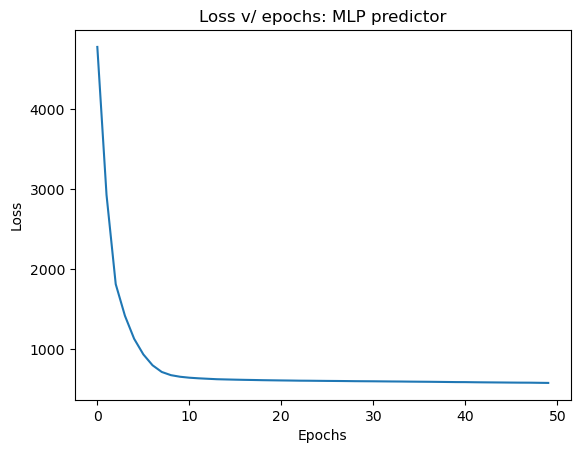

In [38]:
training.history['loss']

plt.plot(training.epoch, training.history['loss'])
plt.title('Loss v/ epochs: MLP predictor')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

In [27]:
## Evaluando el modelo

results = model.evaluate(x_test, y_test, batch_size = 1000)
print("rmse, rsq: ", math.sqrt(results[0]), results[1])

4/4 [==============================] - 0s 9ms/step - loss: 558.6396 - r2_score: 0.2876
rmse, rsq:  23.63555769179868 0.28761011362075806


2022-10-01 21:42:45.939234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [28]:
## Generando predicciones

predict_train = model.predict(x_train)
predict_test = model.predict(x_test)

  1/409 [..............................] - ETA: 19s

2022-10-01 21:42:46.101666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


110/110 [==============================] - 0s 2ms/step


In [29]:
min(predict_train), max(predict_test)

(array([35.203995], dtype=float32), array([115.14395], dtype=float32))

## Construyendo el modelo de RBF

In [30]:
# creating RBF network

rbflayer = RBFLayer(10,
                      initializer = InitCentersKMeans(x_train),
                      betas = 0.05,
                      input_shape = (num_features,))

In [31]:
model1 = Sequential()
model1.add(rbflayer)
model1.add(Dense(1, use_bias=False))

In [32]:
model1.compile(
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
    loss = keras.losses.MeanSquaredError(),
    metrics = [r2_score],
)

In [33]:
# Entrenando el modelo

training2 = model1.fit(
    x_train,
    y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_val, y_val),
)

Epoch 1/50
 10/131 [=>............................] - ETA: 0s - loss: 5454.3188 - r2_score: -5.7859 

2022-10-01 21:42:47.810183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 1s 7ms/step - loss: 4741.9570 - r2_score: -4.9154 - val_loss: 3961.0225 - val_r2_score: -4.0226
Epoch 2/50
 21/131 [===>..........................] - ETA: 0s - loss: 4235.2495 - r2_score: -4.4855

2022-10-01 21:42:48.728908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 1s 6ms/step - loss: 4052.2314 - r2_score: -4.0661 - val_loss: 3735.9995 - val_r2_score: -3.7340
Epoch 3/50
131/131 [==============================] - 1s 6ms/step - loss: 3782.4216 - r2_score: -3.7499 - val_loss: 3441.6636 - val_r2_score: -3.3579
Epoch 4/50
131/131 [==============================] - 1s 6ms/step - loss: 3493.5928 - r2_score: -3.3867 - val_loss: 3219.8647 - val_r2_score: -3.0745
Epoch 5/50
131/131 [==============================] - 1s 6ms/step - loss: 3292.7046 - r2_score: -3.1081 - val_loss: 3062.0215 - val_r2_score: -2.8741
Epoch 6/50
131/131 [==============================] - 1s 6ms/step - loss: 3100.4695 - r2_score: -2.8702 - val_loss: 2875.4636 - val_r2_score: -2.6351
Epoch 7/50
131/131 [==============================] - 1s 6ms/step - loss: 2933.5669 - r2_score: -2.6738 - val_loss: 2743.5994 - val_r2_score: -2.4673
Epoch 8/50
131/131 [==============================] - 1s 6ms/step - loss: 2772.5427 - r2_score: -2.4631 - val_l

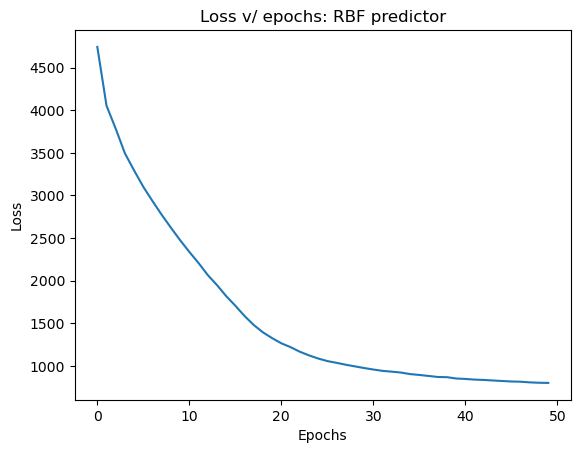

In [34]:
training2.history['loss']

plt.plot(training2.epoch, training2.history['loss'])
plt.title('Loss v/ epochs: RBF predictor')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

In [35]:
results = model1.evaluate(x_test, y_test, batch_size = 1000)
print("rmse, rsq: ", math.sqrt(results[0]), results[1])

4/4 [==============================] - 0s 9ms/step - loss: 751.4498 - r2_score: 0.0395
rmse, rsq:  27.412584118729235 0.03945133090019226


2022-10-01 21:43:28.967709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [36]:
predict_train1 = model1.predict(x_train)
predict_test1 = model1.predict(x_test)

  1/409 [..............................] - ETA: 14s

2022-10-01 21:43:29.119196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


110/110 [==============================] - 0s 2ms/step


In [37]:
max(predict_train1), min(predict_train1)

(array([121.256775], dtype=float32), array([51.340862], dtype=float32))